Import a couple of libraries we are going to use:

In [1]:
import rasterio
import bokeh
import urllib.request
import zipfile
import os

Download and a multi-layer GeoTIFF, but **only** if it hasn't been downloaded and unzipped before:

In [2]:
if os.path.isfile('Africa.tif'):
    print("Africa.tif already downloaded and unzipped.")
else:
    urllib.request.urlretrieve("https://carsten.io/Africa.zip", "Africa.zip")
    zf = zipfile.ZipFile("Africa.zip")
    zf.extractall()
    os.remove("Africa.zip") # clean up
    print("Download and unzip complete.")

Africa.tif already downloaded and unzipped.


Let's open the file with rasterio:

In [3]:
africa_tif = rasterio.open('Africa.tif')

Print some information about the dataset:

In [ ]:
print("The file is called", africa_tif.name)
print()
print("It is", africa_tif.width, "x",africa_tif.height,"pixels big")
print()
print("It covers the following extent:",africa_tif.bounds)
print()
print("It is in the following CRS:",africa_tif.crs)

How many layers are there in this GeoTIFF, and what data types do they use?

In [ ]:
{i: dtype for i, dtype in zip(africa_tif.indexes, africa_tif.dtypes)}

Let's take a look at the layers:

In [ ]:
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
plt.figure(figsize=(14, 14))
show((africa_tif, 1), title='Countries', cmap='prism')

In [ ]:
plt.figure(figsize=(14, 14))
show((africa_tif, 3), title='Urban Areas', cmap='Greys')


In [ ]:
plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population')

Not great, let's try to improve this:

In [ ]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population', norm=LogNorm(), cmap='hot_r')

Can we add a legend?

In [4]:
pop = africa_tif.read(2)

In [ ]:
plt.figure(figsize=(14, 14))

imgplot = plt.imshow(pop, norm=LogNorm(), cmap='hot_r')
plt.colorbar()

Alternative: Interactive plots with Bokeh:

In [5]:
import numpy as np
import bokeh.plotting as bkplt

In [6]:
p = bkplt.figure(x_range=(0, pop.shape[0]), y_range=(0, pop.shape[1]))

# must give a vector of image data for image parameter
p.image(image=[pop], x=0, y=0, dw=pop.shape[0], dh=pop.shape[1], palette="Spectral11")

bkplt.show(p)

Bokeh can also make web maps:

In [8]:
from bokeh.tile_providers import CARTODBPOSITRON

# range bounds supplied in web mercator coordinates
p = bkplt.figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

bkplt.show(p)

# Compression

In [42]:
def compress(inputfile, outputfile, layer, compression, datatype):
    
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = inputfile.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=datatype,
            count=1,
            compress=compression)

        with rasterio.open(outputfile, 'w', **profile) as dst:
            dst.write(layer.astype(datatype), 1)

In [ ]:
compress(africa_tif, 'pop-float.tif',     pop, None, rasterio.float32)
compress(africa_tif, 'pop-float-lzw.tif', pop, 'lzw', rasterio.float32)
compress(africa_tif, 'pop-int-lzw.tif',   pop, 'lzw', rasterio.int32)

Let's do the urban layer to test int8:

In [43]:
urban = africa_tif.read(3)
compress(africa_tif, 'urban-int-lzw.tif', urban, 'lzw', rasterio.int8)

# Map Algebra

In [9]:
import seaborn as sns     
from scipy import signal  # for the focal function
from skimage import graph # can do least cost

Let's define two layers, let's say one is ground elevation, the other one is the height of vegeation above ground:


In [10]:
elevation = np.array([ [ 1, 1, 3, 4, 4, 2],
                       [ 1, 3, 4, 4, 2, 1],
                       [ 1, 2, 2, 3, 2, 0],
                       [ 1, 1, 2, 4, 0, 0]])

building = np.array([ [0, 1, 1, 1, 1, 2],
                       [ 1, 1, 1, 1, 1, 1],
                       [ 0, 1, 2, 3, 4, 0],
                       [ 0, 1, 0, 1, 0, 0]])

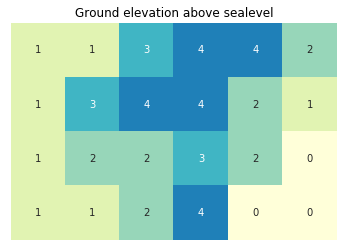

In [11]:
fig = sns.heatmap(elevation, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cmap="YlGnBu", cbar=False, vmin=0, vmax=6).set_title('Ground elevation above sealevel')

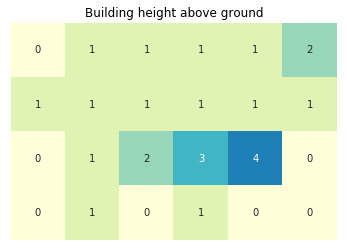

In [12]:
fig = sns.heatmap(building, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Building height above ground')

### 1. Local operation: Calculate building height above sea level

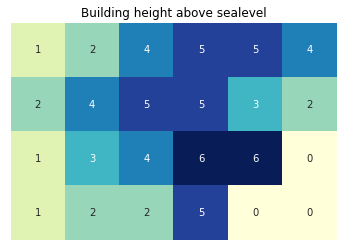

In [13]:
building_above_sealevel = elevation + building

fig = sns.heatmap(building_above_sealevel, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Building height above sealevel')

### 2. Focal operation: Fix errors in elevation raster

Let's assume our elevation raster has a measurement error, e.g. because a bird flew under the LiDAR, so one pixel has  a too high value:

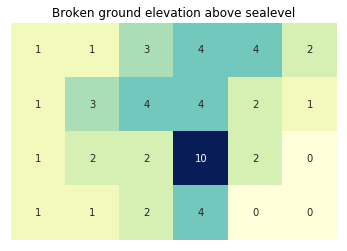

In [14]:
broken_elevation = elevation
broken_elevation[2,3] = 10

fig = sns.heatmap(broken_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Broken ground elevation above sealevel')

We'll fix this by running a 3x3 window over it that sets every pixel to the average of it's 8 neighbors:

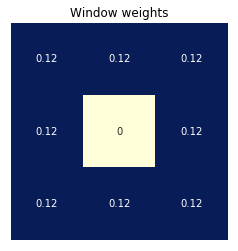

In [15]:
window = np.array([ [ 1/8., 1/8., 1/8.,],
                    [ 1/8., 0, 1/8.,],
                    [ 1/8., 1/8., 1/8.,],])

fig = sns.heatmap(window, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Window weights')

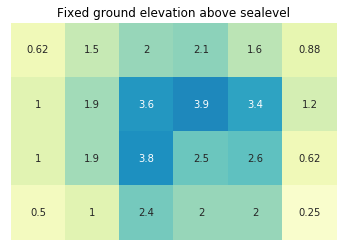

In [16]:
fixed_elevation = signal.convolve(broken_elevation, window, mode="same") # "moving window" function

fig = sns.heatmap(fixed_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Fixed ground elevation above sealevel')

Note that functions like this one always affect **all cells** (not just the "broken" one) and have **edge effects**!

## 3. Zonal operation: Average vegetation height per zone

Let's define two zones and calculate the average vegetation height per zone:

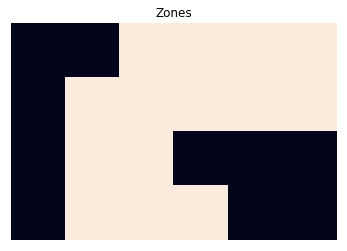

In [17]:
zones = np.array([ [0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 0],
                   [0, 1, 1, 1, 0, 0]])

fig = sns.heatmap(zones, square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Zones')

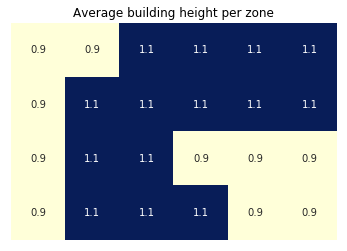

In [18]:
avg_veg_height = np.copy(zones).astype(float)

for zone in np.unique(zones):
    avg_veg_height[zones == zone] = np.mean(building[zones == zone])
    
fig = sns.heatmap(avg_veg_height, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, 
                  cbar=False).set_title('Average building height per zone')

## 4. Global operation: Cost distance

We'll use or elevation layer as a cost surface and calculate the cost to travel to each cell from a given start cell.

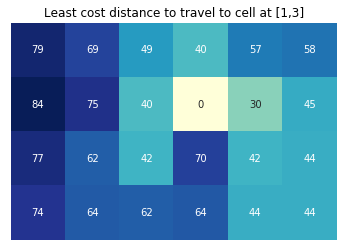

In [19]:
# turn our elevation into a cost surface
cellSize = 10
lg = graph.MCP_Geometric(elevation, sampling=(cellSize, cellSize))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=[(1, 3)])[0]
fig = sns.heatmap(lcd, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Least cost distance to travel to cell at [1,3]')

Calculate an example path, here from the top left pixel to our source, using [route_through_array](http://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#route-through-array)

In [20]:
from skimage.graph import route_through_array

In [21]:
route_through_array(elevation, [0, 1], [1, 3])

([(0, 1), (0, 2), (1, 3)], 6.949747468305833)

# Numpy

In [22]:
pop

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [29]:
pop.size

107877571

In [23]:
pop.shape

(10117, 10663)

In [30]:
pop[pop > 1000]

array([1258, 1284, 1265, ..., 3198, 2527, 1315], dtype=int16)

In [49]:
countries = africa_tif.read(1)

In [50]:
egypt = countries == 818 # = Egypt
egypt

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Combining layers!

In [51]:
np.sum(pop[egypt]) # what is happening here?

81662875

Wait, what? Let's fix that:

In [52]:
pop[pop < 0] = 0 

In [53]:
popegypt = np.sum(pop[egypt]) 
"{:,}".format(popegypt)

'81,662,875'

Identify the urban and rural cells in Egypt:

In [54]:
cities = urban == 2
rural  = urban == 1

Now we can count them to calculate the number of urban and rural cells in Egypt (or any other country) in 2010:

In [56]:
urbanEgypt = np.all((egypt, cities), axis=0)
ruralEgypt = np.all((egypt, rural), axis=0)

When applied to boolean arrays, [np.sum](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.sum.html) treats ```True``` like 1 and ```False``` like 0:

In [58]:
print("Urban cells in Egypt:","{:,}".format(np.sum(urbanEgypt)))
print("Rural cells in Egypt:","{:,}".format(np.sum(ruralEgypt)))

Urban cells in Egypt: 33,689
Rural cells in Egypt: 1,267,349


## Can we calculate the urban area from this?

Let's take a look [here](https://bl.ocks.org/atanumallick/8d18989cd538c72ae1ead1c3b18d7b54) and [here](https://bl.ocks.org/syntagmatic/ba569633d51ebec6ec6e)